In [1]:
import numpy as np
import tensorflow as tf

# RHIRL
# import sys
# sys.path.append("../../irl/rhirl/")
# from rhirl import *
# from rhirl_plotting import *

# Simple RL
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# MLIRL [1]

In [2]:
def MLIRL(state_trajectories, action_trajectories,
          states, state_features, 
          actions, trans_dict, optimizer_fn,
          n_iter=1, n_vi_iter=1,
          gamma=0.99, boltzmann_beta=1., 
          dtype=torch.float, print_interval=1):
    
    nS = len(states)
    nA = len(actions)
    state_features = torch.from_numpy(state_features).type(dtype)
    feature_dim = state_features.shape[1]
    state_to_idx = {s:idx for idx,s in enumerate(states)}
    action_to_idx = {a:idx for idx,a in enumerate(actions)}
    softmax = torch.nn.Softmax(dim=0)
    # Reward parameters
    w = Variable(torch.Tensor(feature_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True) # weight init normal random
    # w = Variable(torch.Tensor(feature_dim, 1).type(dtype), requires_grad=True) # weight init zero
    # torch.ones(feature_dim, 1, dtype=dtype, requires_grad=True)
    optimizer = optimizer_fn([w])
    
    for _iter in range(n_iter):
        # Stochastic Policy
        Pi = torch.ones(nS, nA, dtype=dtype) / nA
        # Reward^~
        R = torch.mm(state_features, w)
        # Value
        V = R[:,0].clone()
        # V = gtorch.zeros(nS, dtype=dtype)
        # Q value
        Q = R.repeat(1,nA).clone()
        # Q = torch.zeros(nS, nA, dtype=dtype)

        for _v_iter in range(n_vi_iter):
            for s_idx, s in enumerate(states):
                
                # Check if state is terminal (stop leaking values back to non-goal state space)
                if s.is_terminal():
                    continue
                    
                phi_s = state_features[s_idx] #torch.from_numpy(phi(s)).type(dtype)
                for a_idx, a in enumerate(actions):

                    Q[s_idx, a_idx] = R[s_idx]
                    for s_prime in trans_dict[s][a]:
                        Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[state_to_idx[s_prime]].clone()
                    Pi[s_idx, :] = softmax(boltzmann_beta * Q[s_idx,:].clone())
                    V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
                    
        optimizer.zero_grad()
        loss = 0
        for traj_idx, state_trajectory in enumerate(state_trajectories):
            for point_idx, state in enumerate(state_trajectory[:-1]):
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action_trajectories[traj_idx][point_idx]]
                loss -= torch.log(Pi[s_idx,a_idx])
        loss.backward()
        if _iter % print_interval == 0 or _iter == n_iter-1:
            print("Iter: {:04d}, loss: {:012.6f}, w: [{}], dw: [{}]".format(
                _iter, loss, ' '.join("{:+10.8f}".format(v) for v in w[:,0]), ' '.join("{:+10.9f}".format(v) for v in -w.grad[:,0])))
        optimizer.step()
    return w, R, Pi, V, Q, loss


# Experiments

In [7]:
def get_action(state, n_state):
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0:
        return "right"
    elif dx > 0 and dy > 0:
        return "up_right"
    elif dx == 0 and dy > 0:
        return "up"
    elif dx < 0 and dy > 0:
        return "up_left"
    elif dx < 0 and dy == 0:
        return "left"
    elif dx < 0 and dy < 0:
        return "down_left"
    elif dx == 0 and dy < 0:
        return "down"
    elif dx > 0 and dy < 0:
        return "down_right" 
    else: #dx == 0 and dy == 0:
        return "None"

def get_actions_from_state_traj(state_traj):
    return [get_action(state_traj[i], state_traj[i+1]) for i in range(len(state_traj)-1)]

def map_v_to_grid(states, V, nvmdp):
    V_grid = np.zeros((nvmdp.height, nvmdp.width))
    for i in range(len(states)):
        r, c = nvmdp._xy_to_rowcol(states[i].x, states[i].y)
        V_grid[r,c] = V[i]
    return V_grid

def MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=True, figsize=(10,10), print_interval=1):
    
    if "goal_locs" not in irl_problem:
        irl_problem["goal_locs"] = []
        irl_problem["goal_types"] = []
        irl_problem["goal_types"] = []
        
    # Navigation MDP with no goals
    nvmdp = NavigationMDP(width=irl_problem["width"], height=irl_problem["height"],
                          living_cell_types=irl_problem["cell_types"],
                          living_cell_rewards=[0]*len(irl_problem["cell_types"]),
                          living_cell_distribution="manual",
                          living_cell_locs=irl_problem["cell_locs"],
                          goal_cell_locs=irl_problem["goal_locs"],
                          goal_cell_types=irl_problem["goal_types"],
                          goal_cell_rewards=[0]*len(irl_problem["goal_types"]))
    # Visualize Grid
    if disp_grid:
        nvmdp.visualize_grid(nvmdp.state_space, trajectories=irl_problem["traj_states"], 
                             state_space_cmap=plt.cm.viridis, end_marker="*k", goal_marker_sz=10, title=irl_problem["title"])
    
    # MLIRL Inputs
    phi = lambda s: nvmdp.feature_at_state(s, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    phi_loc = lambda x,y: nvmdp.feature_at_loc(x, y, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    states = nvmdp.get_states()
    actions = nvmdp.get_actions()
    state_features = np.asarray([phi(s) for s in states])
    cell_features = np.asarray([[phi_loc(*nvmdp._rowcol_to_xy(row,col)) for col in range(nvmdp.width)] for row in range(nvmdp.height)])
    T = nvmdp.get_trans_dict()
    # MLIRL
    print("Training...\n \t\t\t\t \t {}  \t {} ".format(' '.join("{:11}".format(v) for v in nvmdp.cell_types), ' '.join("{:11}".format(v) for v in nvmdp.cell_types)))
    w, _, Pi, V, Q, loss = MLIRL(irl_problem["traj_states"], irl_problem["traj_actions"], states, state_features, actions, T, **mlirl_params, print_interval=print_interval)
    print("Done.")
    # Recovered Reward
    R = cell_features.dot(w.data)[:,:,0]
    # Map values to grid
    V_grid = map_v_to_grid(states, V, nvmdp)
    
    # Display results
    if disp_results:
        display_irl_results(nvmdp, irl_problem["traj_states"], R, V_grid, title, figsize)
    return dict(w=w, R=R, Pi=Pi, V=V, Q=Q, nvmdp=nvmdp, phi=phi, phi_loc=phi_loc, V_grid=V_grid)

def display_irl_results(nvmdp, tau_s, recovered_R, V=None, title="", rewards_cmap=None, figsize=(16,8)):
    
    plt.figure(figsize=figsize)
    nvmdp.visualize_grid(nvmdp.state_space, new_fig=False, subplot_str="221", trajectories=tau_s, 
                         state_space_cmap=True, show_colorbar=False, end_marker="*k", title=title)
    nvmdp.visualize_grid(recovered_R, new_fig=False, subplot_str="222", cmap=rewards_cmap, state_space_cmap=False,
                         show_colorbar=True, text_values=recovered_R, text_size=10, title="MLIRL Recovered R")
    if V is not None:
        #plt.figure(figsize=(figsize[0],int(1*figsize[1]/2)))
        nvmdp.visualize_grid(V, new_fig=False, subplot_str="223", state_space_cmap=False, show_colorbar=True, text_values=V, text_size=10, title="MLIRL V")        

### Michael Littman MDP (RL class)

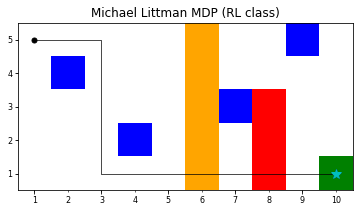

Training...
 				 	 white       blue        orange      red         green        	 white       blue        orange      red         green       
Iter: 0000, loss: 00018.024448, w: [-0.00902600 +0.00228575 +0.00018539 -0.00649506 -0.00954762], dw: [-0.041901737 -0.302118063 -0.002869342 +0.008502577 +0.236871064]
Iter: 0001, loss: 00018.009295, w: [-0.01231358 -0.02815463 -0.00012008 -0.00499529 +0.01509425], dw: [-0.042979807 -0.300234973 -0.003136448 +0.008379711 +0.236580551]
Iter: 0002, loss: 00017.982229, w: [-0.01833902 -0.08275901 -0.00069664 -0.00230801 +0.05942056], dw: [-0.044875264 -0.296886295 -0.003618015 +0.008157661 +0.236055627]
Iter: 0003, loss: 00017.947462, w: [-0.02641554 -0.15331566 -0.00150769 +0.00115712 +0.11697774], dw: [-0.047241837 -0.292617887 -0.004246716 +0.007865181 +0.235369101]
Iter: 0004, loss: 00017.909540, w: [-0.03576704 -0.23074688 -0.00251153 +0.00494654 +0.18061835], dw: [-0.049715161 -0.288015902 -0.004949702 +0.007533451 +0.234602779]
Done.


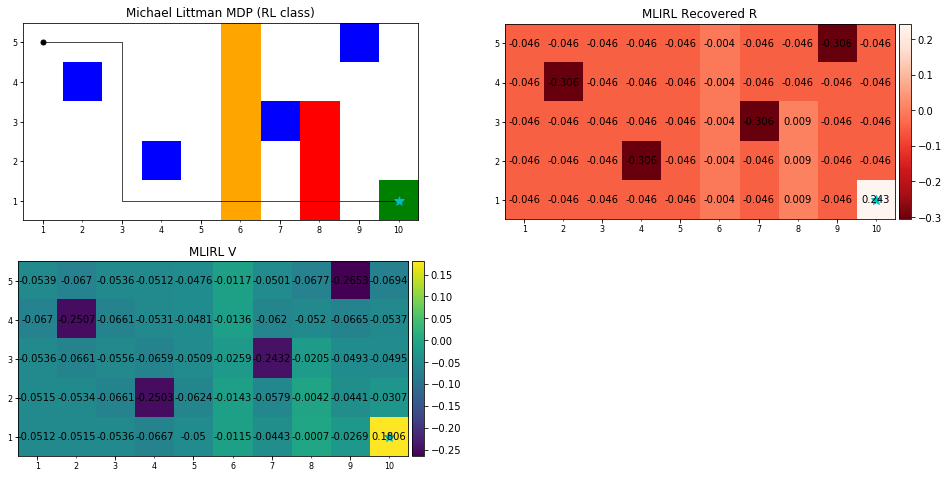

In [4]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', 'blue', "orange", "red"],
    cell_locs = [np.inf, [(2,4), (4,2), (7,3), (9,5)], [(6,i) for i in range(1,6)], [(8,i) for i in range(1,4)]],
    goal_types = ["green"],
    goal_locs = [(10, 1)],
    tau_s = [[(1,5),(2,5)] + [(3,i) for i in range(5,0,-1)] + [(i,1) for i in range(4,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Michael Littman MDP (RL class)",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

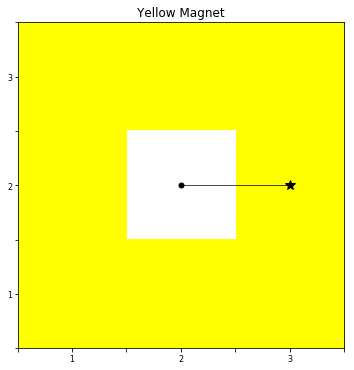

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00001.386294, w: [-0.00638604 +0.00795010], dw: [+0.000000001 -0.000000083]
Iter: 0001, loss: 00001.386294, w: [-0.00632218 +0.00787060], dw: [+0.000000002 -0.000000027]
Iter: 0002, loss: 00001.386294, w: [-0.00620149 +0.00772034], dw: [-0.000000000 -0.000000031]
Iter: 0003, loss: 00001.386294, w: [-0.00603084 +0.00750791], dw: [-0.000000000 -0.000000059]
Iter: 0004, loss: 00001.386294, w: [-0.00581696 +0.00724163], dw: [+0.000000001 +0.000000034]
Done.


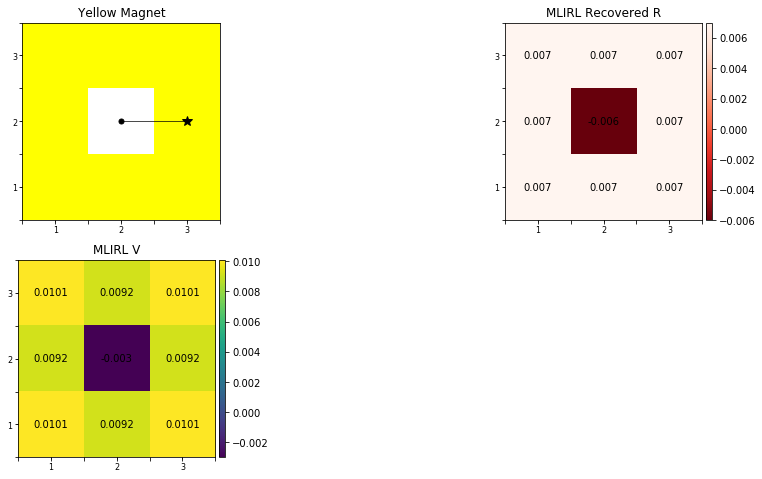

In [8]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Yellow Magnet

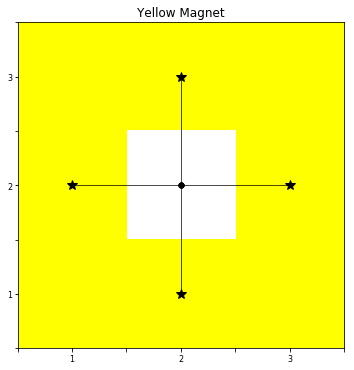

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00005.545177, w: [-0.01309139 +0.00979289], dw: [-0.000000000 -0.000000000]
Iter: 0001, loss: 00005.545177, w: [-0.01296047 +0.00969496], dw: [-0.000000000 -0.000000000]
Iter: 0002, loss: 00005.545177, w: [-0.01271305 +0.00950988], dw: [-0.000000000 -0.000000000]
Iter: 0003, loss: 00005.545177, w: [-0.01236323 +0.00924820], dw: [-0.000000000 -0.000000000]
Iter: 0004, loss: 00005.545177, w: [-0.01192477 +0.00892021], dw: [-0.000000000 -0.000000000]
Done.


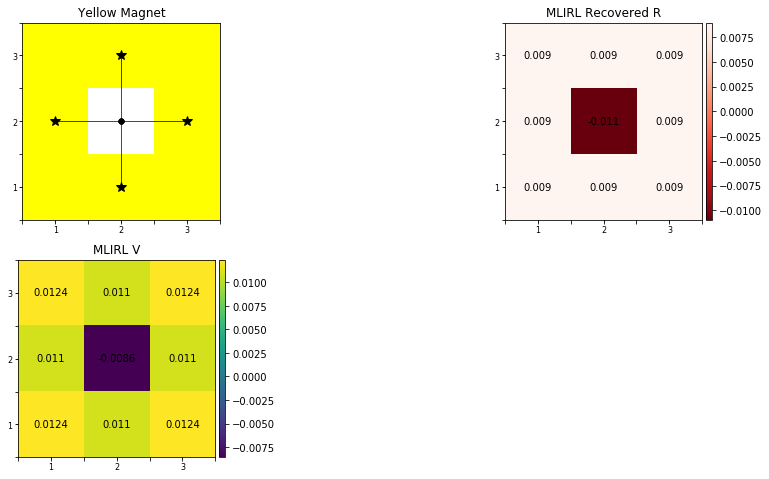

In [9]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,1)], [(2,2),(2,3)], [(2,2),(1,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Contradiction

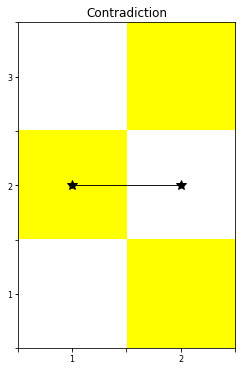

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00002.772595, w: [+0.00809492 -0.01219375], dw: [-0.000660196 +0.000660203]
Iter: 0001, loss: 00002.772595, w: [+0.00800737 -0.01206521], dw: [-0.000653133 +0.000653297]
Iter: 0002, loss: 00002.772595, w: [+0.00784197 -0.01182234], dw: [-0.000639923 +0.000639938]
Iter: 0003, loss: 00002.772595, w: [+0.00760829 -0.01147914], dw: [-0.000621036 +0.000621282]
Iter: 0004, loss: 00002.772594, w: [+0.00731569 -0.01104925], dw: [-0.000597611 +0.000597760]
Done.


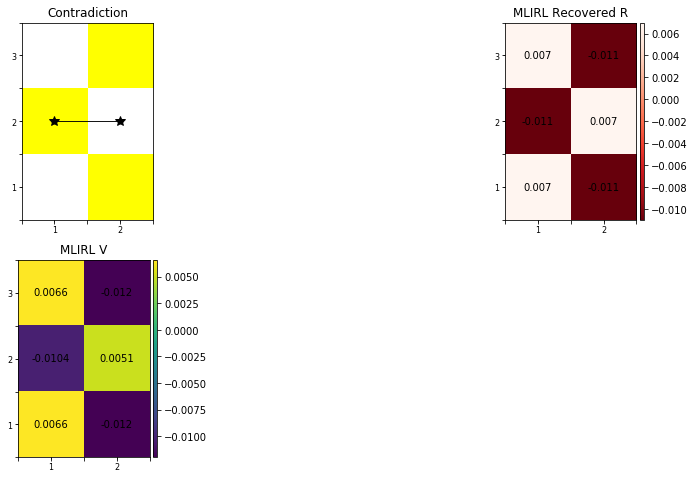

In [10]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 2,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,2),(2,3),(2,1)]],
    tau_s = [[(2,2),(1,2)], [(1,2),(2,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Contradiction

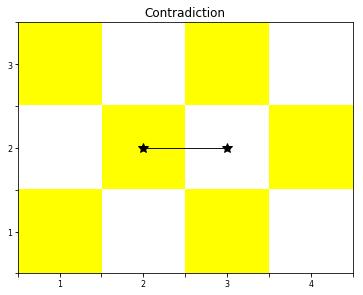

Training...
 				 	 white       yellow       	 white       yellow      
Iter: 0000, loss: 00002.772589, w: [+0.00052996 -0.00847131], dw: [-0.000114840 +0.000114942]
Iter: 0001, loss: 00002.772589, w: [+0.00052352 -0.00838544], dw: [-0.000113701 +0.000113706]
Iter: 0002, loss: 00002.772589, w: [+0.00051134 -0.00822318], dw: [-0.000111413 +0.000111436]
Iter: 0003, loss: 00002.772589, w: [+0.00049415 -0.00799379], dw: [-0.000108154 +0.000108409]
Iter: 0004, loss: 00002.772589, w: [+0.00047266 -0.00770632], dw: [-0.000104250 +0.000104486]
Done.


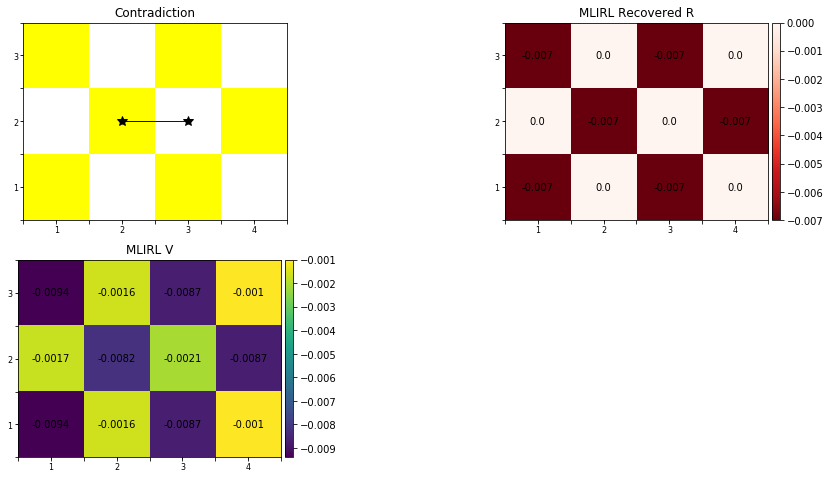

In [11]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 4,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,3),(1,1),(2,2),(3,3),(3,1),(4,2)]],
    tau_s = [[(3,2),(2,2)], [(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

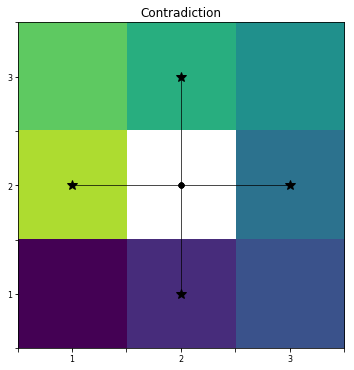

Training...
 				 	 white                 0           1           2           3           4           5           6           7  	 white                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00005.545197, w: [+0.00191719 -0.00647803 +0.01801062 -0.00961151 -0.00890182 +0.01177343 -0.00322389 +0.01387127 -0.00469163], dw: [-0.000000642 -0.000105952 -0.001701213 -0.000061399 +0.000998765 +0.000107182 +0.000205673 +0.000062306 +0.000494583]
Iter: 0001, loss: 00005.545197, w: [+0.00189801 -0.00641431 +0.01781350 -0.00951601 -0.00880282 +0.01165677 -0.00318959 +0.01373318 -0.00463976], dw: [-0.000000124 -0.000104771 -0.001682275 -0.000060710 +0.000987784 +0.000105990 +0.000203362 +0.000061612 +0.000489153]
Iter: 0002, loss: 00005.545196, w: [+0.00186177 -0.00629387 +0.01744113 -0.00933551 -0.00861581 +0.01143627 -0.00312480 +0.01347218 -0.00454180], dw: [-0.000000313 -0.000102554 -0.001646581 -0.000059431 +0.000966853 +0.000

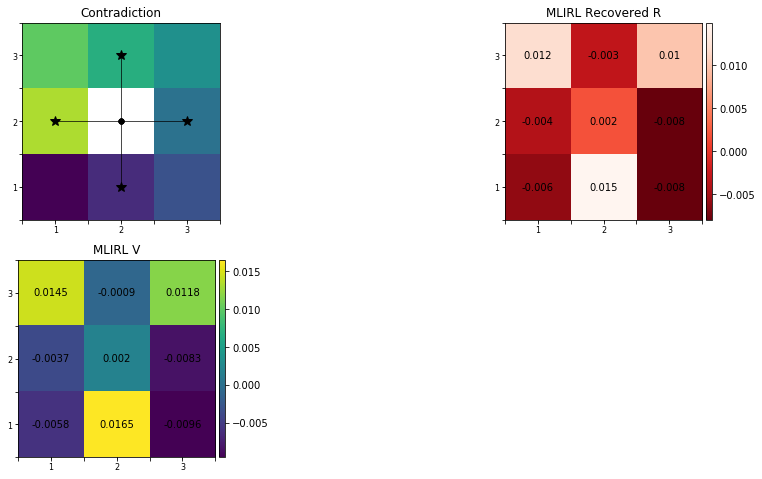

In [14]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white'] + list(range(0,8)),
    cell_locs = [[(2,2)], [(1,1)], [(2,1)], [(3,1)], [(3,2)], [(3,3)], [(2,3)], [(1,3)], [(1,2)]],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,3)], [(2,2),(1,2)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Vertical Spread

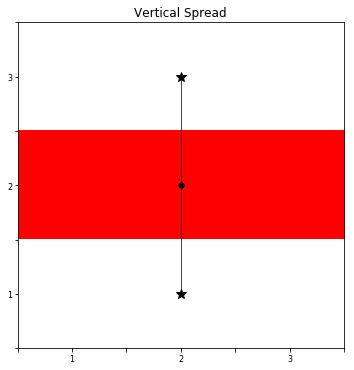

Training...
 				 	 white       red          	 white       red         
Iter: 0000, loss: 00002.776046, w: [-0.00108003 +0.00956904], dw: [+0.324929863 -0.324929714]
Iter: 0001, loss: 00002.773901, w: [+0.00218007 +0.00622405], dw: [+0.324554294 -0.324554563]
Iter: 0002, loss: 00002.769856, w: [+0.00833790 -0.00009422], dw: [+0.323844939 -0.323844939]
Iter: 0003, loss: 00002.764158, w: [+0.01703501 -0.00901818], dw: [+0.322842747 -0.322842658]
Iter: 0004, loss: 00002.757052, w: [+0.02792050 -0.02018798], dw: [+0.321588069 -0.321588039]
Done.


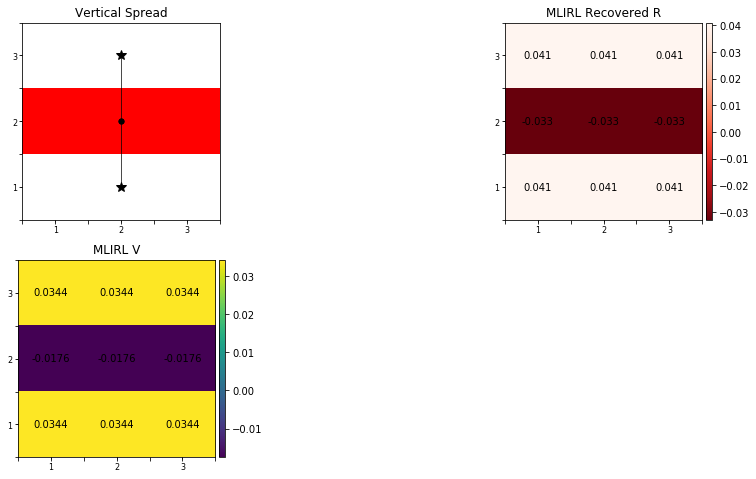

In [12]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'red'],
    cell_locs = [np.inf, [(i,2) for i in range(1,4)]],
    tau_s = [[(2,2),(2,3)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Vertical Spread",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Speed Bump MDP

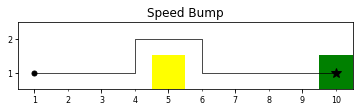

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.252930, w: [+0.01411083 -0.00614700 -0.01499942], dw: [-0.059182286 -0.223616406 +0.282798886]
Iter: 0001, loss: 00015.251558, w: [+0.01337790 -0.00832169 -0.01202144], dw: [-0.059270851 -0.223534331 +0.282805473]
Iter: 0002, loss: 00015.248964, w: [+0.01199177 -0.01243104 -0.00639298], dw: [-0.059437655 -0.223379508 +0.282817632]
Iter: 0003, loss: 00015.245301, w: [+0.01002997 -0.01823894 +0.00156473], dw: [-0.059673458 -0.223161027 +0.282834649]
Iter: 0004, loss: 00015.240709, w: [+0.00756731 -0.02551527 +0.01153937], dw: [-0.059967604 -0.222887769 +0.282855719]
Done.


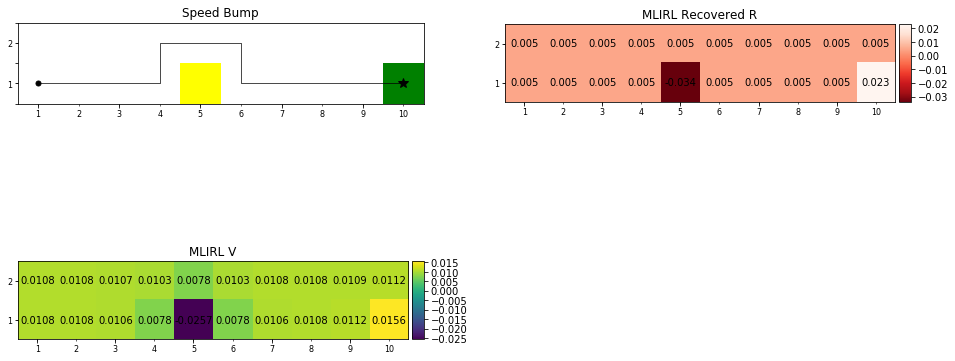

In [15]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 100,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 2,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,1)]],
    tau_s = [[(i,1) for i in range(1,5)] + [(4,2), (5,2), (6,2)] + [(i,1) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Ripples

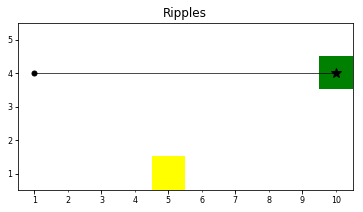

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00012.472866, w: [-0.00454483 -0.00975211 +0.00965468], dw: [-0.265514493 -0.000639523 +0.266154051]
Iter: 0001, loss: 00012.471492, w: [-0.00715452 -0.00966098 +0.01221967], dw: [-0.265515029 -0.000640499 +0.266155154]
Iter: 0002, loss: 00012.468892, w: [-0.01208685 -0.00948877 +0.01706752], dw: [-0.265515566 -0.000642346 +0.266157538]
Iter: 0003, loss: 00012.465216, w: [-0.01906024 -0.00924531 +0.02392148], dw: [-0.265516102 -0.000644966 +0.266160756]
Iter: 0004, loss: 00012.460608, w: [-0.02780084 -0.00894019 +0.03251244], dw: [-0.265517116 -0.000648261 +0.266164958]
Done.


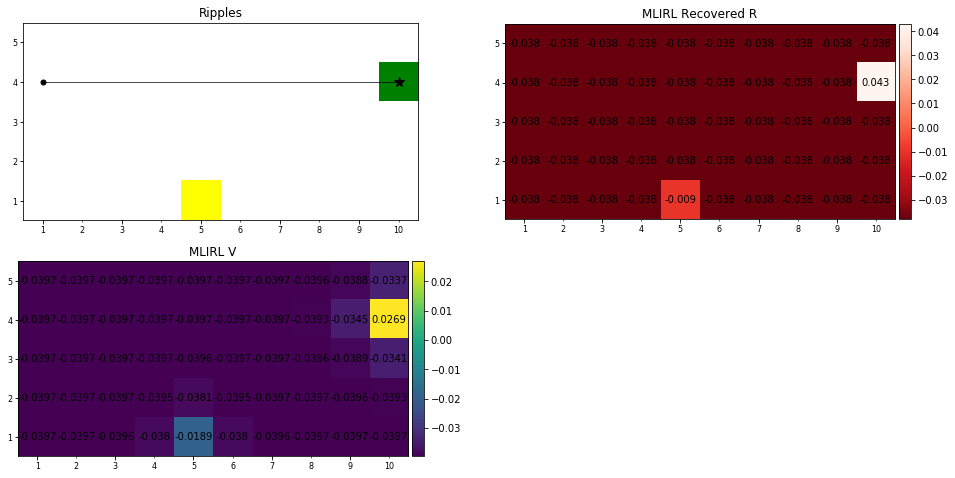

In [18]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 100,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,4)]],
    tau_s = [[(i,yi) for i in range(1,5)] + [(5,yi)] + [(i,yi) for i in range(6,11)]]
    #tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Ripples",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

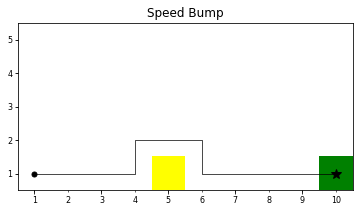

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.244653, w: [-0.00189923 +0.00571082 +0.02017711], dw: [-0.064787492 -0.218060136 +0.282847553]
Iter: 0001, loss: 00015.243381, w: [-0.00252812 +0.00347311 +0.02280382], dw: [-0.064880662 -0.217972606 +0.282853216]
Iter: 0002, loss: 00015.240977, w: [-0.00371764 -0.00075528 +0.02776834], dw: [-0.065056324 -0.217807561 +0.282863796]
Iter: 0003, loss: 00015.237581, w: [-0.00540159 -0.00673136 +0.03478737], dw: [-0.065303661 -0.217574760 +0.282878548]
Iter: 0004, loss: 00015.233326, w: [-0.00751617 -0.01421827 +0.04358541], dw: [-0.065612301 -0.217283472 +0.282896757]
Done.


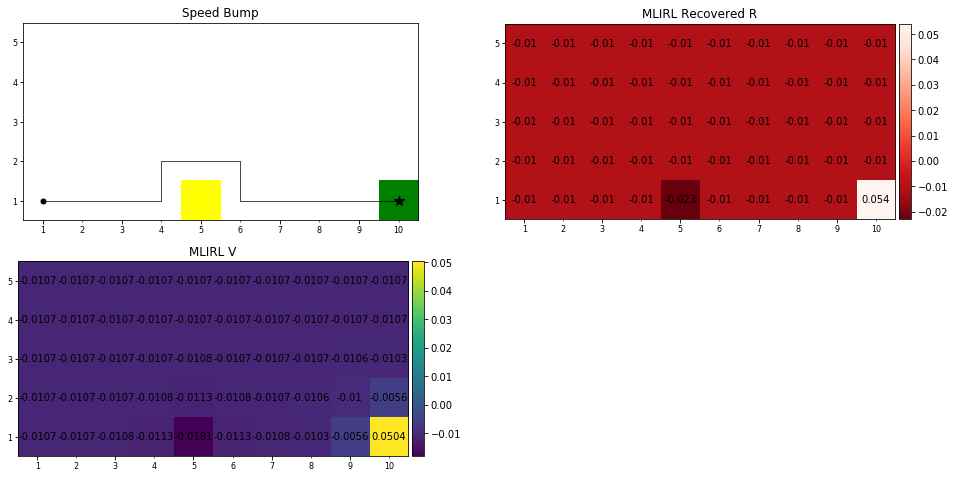

In [19]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
yi = 1
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,yi)]],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

In [1]:
# nvmdp = results["nvmdp"]
# nvmdp._reset_rewards([-1.559, -1.669], [0.661])
# nvmdp.value_iter.gamma = 0.30
# nvmdp.run_value_iteration()
# plt.imshow(nvmdp.get_value_grid())

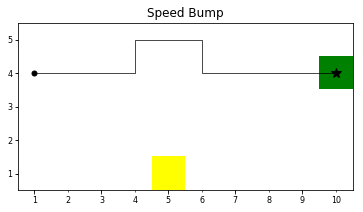

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00015.238242, w: [-0.00799248 +0.00347700 +0.00163974], dw: [-1.153081179 -0.041270640 +1.194350481]
Iter: 0001, loss: 00015.210527, w: [-0.01944336 +0.00302952 +0.01356685], dw: [-1.173672199 -0.042567402 +1.216239333]
Iter: 0002, loss: 00015.156219, w: [-0.04129145 +0.00217082 +0.03632797], dw: [-1.215263963 -0.045168318 +1.260433197]
Iter: 0003, loss: 00015.074625, w: [-0.07269445 +0.00092460 +0.06905402], dw: [-1.280566812 -0.049217265 +1.329785347]
Iter: 0004, loss: 00014.963040, w: [-0.11303587 -0.00069841 +0.11111479], dw: [-1.374380231 -0.055004869 +1.429386139]
Done.


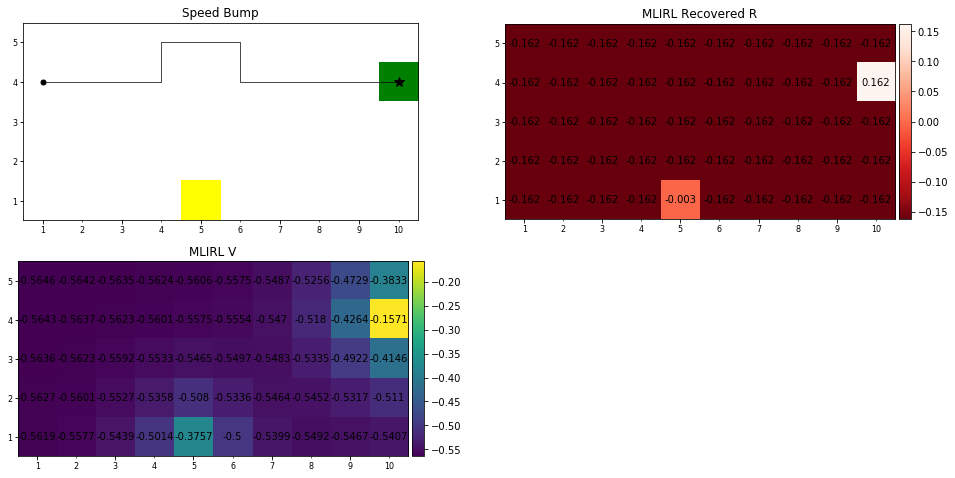

In [23]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
yi = 4
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10, yi)]],
    tau_s = [[(i,yi) for i in range(1,5)] + [(4,yi+1), (5,yi+1), (6,yi+1)] + [(i,yi) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

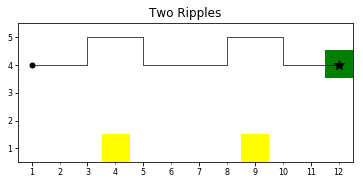

Training...
 				 	 white       yellow      green        	 white       yellow      green       
Iter: 0000, loss: 00020.758171, w: [-0.00675251 -0.01240977 +0.02377432], dw: [-1.114410877 -0.072758019 +1.187166691]
Iter: 0001, loss: 00020.731749, w: [-0.01782909 -0.01301325 +0.03540824], dw: [-1.132681966 -0.075008005 +1.207686663]
Iter: 0002, loss: 00020.704691, w: [-0.02897762 -0.01363320 +0.04713103], dw: [-1.151768327 -0.077347666 +1.229115009]
Iter: 0003, loss: 00020.676933, w: [-0.04020553 -0.01427034 +0.05895087], dw: [-1.171718597 -0.079782262 +1.251501203]
Iter: 0004, loss: 00020.648443, w: [-0.05152066 -0.01492546 +0.07087637], dw: [-1.192574382 -0.082317315 +1.274893999]
Done.


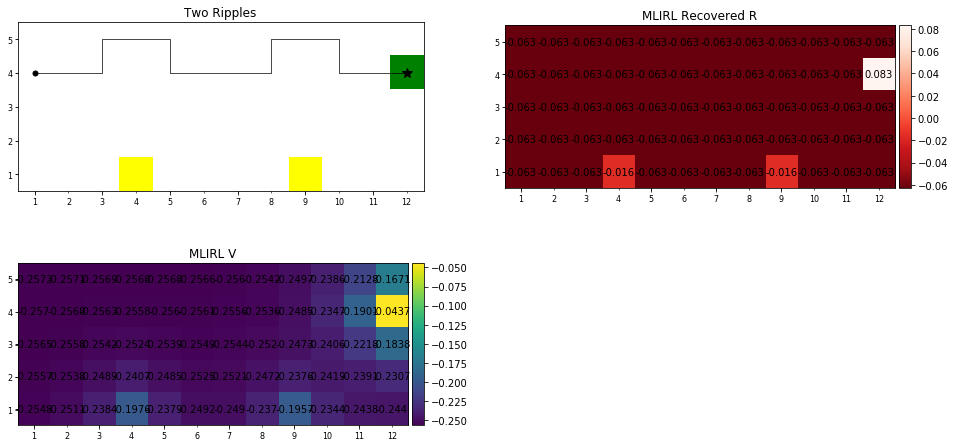

In [22]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.80,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0., weight_decay=1.)
)
mdp_params = dict(
    width = 12,
    height = 5,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(4,1), (9,1)], [(12,4)]],
    tau_s = [[(i,4) for i in range(1,4)] + [(3,5), (4,5), (5,5)] + [(5,4), (6,4), (7,4), (8,4)] +[(8,5), (9,5), (10,5)] + [(10,4), (11,4), (12,4)]]
)
irl_problem = dict(
    mdp_params, 
    title="Two Ripples",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Suspicious Entry

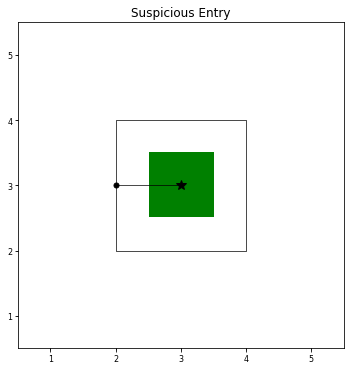

Training...
 				 	 white       green        	 white       green       
Iter: 0000, loss: 00012.484764, w: [+0.00149453 -0.01536138], dw: [-0.461793512 +0.481688261]
Iter: 0001, loss: 00012.480223, w: [-0.00313835 -0.01039089], dw: [-0.463511616 +0.483418673]
Iter: 0002, loss: 00012.471576, w: [-0.01191168 -0.00097935], dw: [-0.466835141 +0.486760587]
Iter: 0003, loss: 00012.459206, w: [-0.02435690 +0.01236844], dw: [-0.471683890 +0.491635859]
Iter: 0004, loss: 00012.443449, w: [-0.04003087 +0.02917412], dw: [-0.477969348 +0.497946560]
Done.


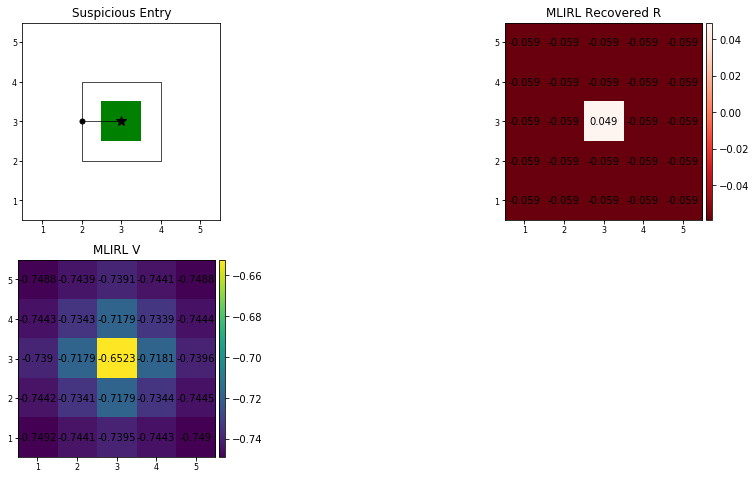

In [24]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"],
    cell_locs = [np.inf, [(3,3)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry", 
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

- How can we learn the exact behavior that's demonstrated here and generalize over new domain?

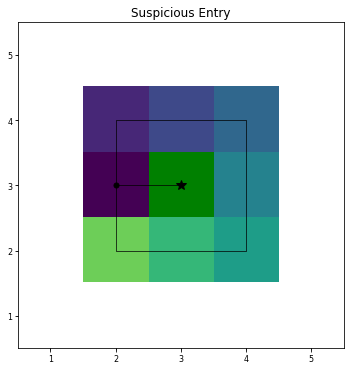

Training...
 				 	 white       green                 0           1           2           3           4           5           6           7  	 white       green                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00012.485909, w: [+0.01090416 -0.01564145 +0.01798892 -0.01906886 -0.00418157 +0.00745365 -0.00439307 +0.00643984 -0.00653387 +0.01836106], dw: [-1.108561516 -0.025737250 +0.148161203 +0.086460061 +0.161185518 +0.163035572 +0.166854680 +0.163208053 +0.161070913 +0.084322937]
Iter: 0001, loss: 00012.471842, w: [-0.00029049 -0.01574240 +0.01929064 -0.01801357 -0.00252790 +0.00900947 -0.00268059 +0.00800752 -0.00485782 +0.01902068], dw: [-1.105771303 -0.026188191 +0.147772089 +0.086189345 +0.160835177 +0.162832096 +0.166534826 +0.163003147 +0.160721168 +0.084072098]
Iter: 0002, loss: 00012.445383, w: [-0.02142049 -0.01593773 +0.02174701 -0.01602178 +0.00059404 +0.01194793 +0.00055279 +0.01096839 -0.00169359 +0.0

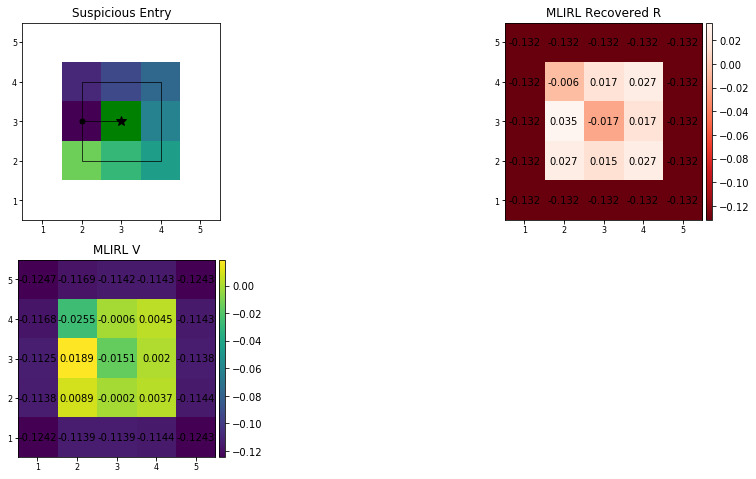

In [25]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

### Walk

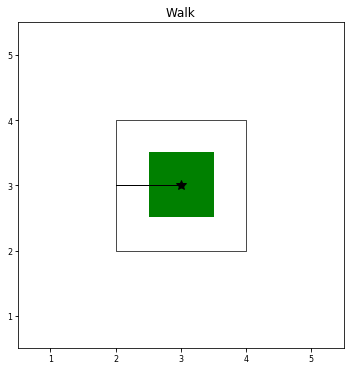

Training...
 				 	 white       green        	 white       green       
Iter: 0000, loss: 00013.862825, w: [+0.01076065 +0.00634512], dw: [+0.027018458 -0.027017564]
Iter: 0001, loss: 00013.862811, w: [+0.01092323 +0.00601149], dw: [+0.026985653 -0.026985250]
Iter: 0002, loss: 00013.862785, w: [+0.01123018 +0.00538126], dw: [+0.026924446 -0.026924305]
Iter: 0003, loss: 00013.862748, w: [+0.01166337 +0.00449099], dw: [+0.026838347 -0.026838137]
Iter: 0004, loss: 00013.862706, w: [+0.01220499 +0.00337647], dw: [+0.026731022 -0.026730502]
Done.


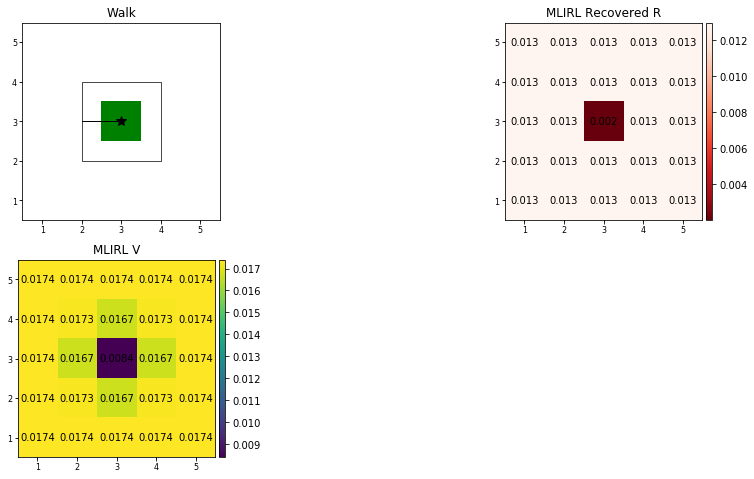

In [26]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"],
    cell_locs = [np.inf, [(3,3)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

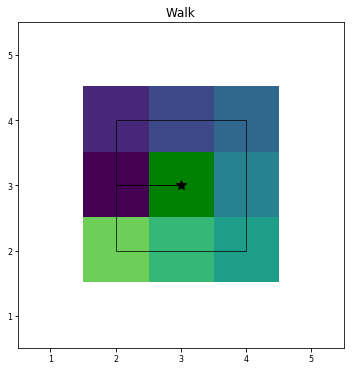

Training...
 				 	 white       green                 0           1           2           3           4           5           6           7  	 white       green                 0           1           2           3           4           5           6           7 
Iter: 0000, loss: 00013.856491, w: [+0.00583897 -0.00579381 +0.03615661 -0.00753127 +0.00454207 -0.00789482 -0.00710264 -0.00730091 +0.00520218 +0.02084267], dw: [-1.106136322 -0.026832428 +0.374907047 +0.097384810 +0.085464329 +0.151890129 +0.090105556 +0.151985332 +0.085251257 +0.095980741]
Iter: 0001, loss: 00013.842050, w: [-0.00528079 -0.00600420 +0.03954412 -0.00648211 +0.00535129 -0.00629697 -0.00613056 -0.00570805 +0.00600267 +0.02159405], dw: [-1.103363991 -0.027268002 +0.374408334 +0.097130612 +0.085164100 +0.151669666 +0.089803673 +0.151763827 +0.084952645 +0.095739484]
Iter: 0002, loss: 00013.814881, w: [-0.02626940 -0.00640618 +0.04594151 -0.00450174 +0.00687772 -0.00327924 -0.00429634 -0.00269976 +0.00751261 +0.0

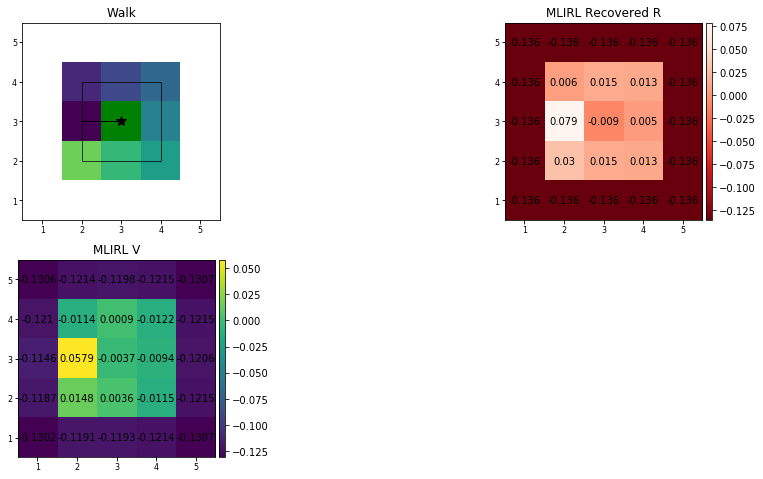

In [27]:
mlirl_params = dict(
    n_iter = 5,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.30,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), results["V_grid"].round(4), irl_problem["title"], rewards_cmap=plt.cm.Reds_r)

Neat!

# References

[1] Babes, Monica, et al. "Apprenticeship learning about multiple intentions." Proceedings of the 28th International Conference on Machine Learning (ICML-11). 2011.